**Entorno:** Anaconda (Python)

_Notebook preparado para ejecutarse en un entorno Anaconda Python local._

---



**BASE DE DATOS III - TAREA N°2**

*Resumen de la tarea*

**Integrantes:**
- Rodrigo Guerrero
- Miguel Espinoza

---

# **DESCRIPCIÓN DEL DATASET**

Conjunto de datos oficiales que recopila indicadores hospitalarios de establecimientos públicos y privados de Chile, correspondientes a procesos de hospitalización registrados por el Ministerio de Salud (MINSAL).
- **Tamaño original**: 155339 filas, 20 columnas
- **Origen**: Evaluación empírica con información de un conjunto de datos hospitalario de Chile


---



# ***VARIABLES DEL DATASET***

**Variable objetivo**
- EFICIENCIA: Esta columna indica si un hospital es eficiente o no (1 = Sí, 0 = No).


**Variables independientes**
- TIPO_PERTENENCIA: Código numérico que identifica la pertenencia del establecimiento (tipo de dato: Entero)

- GLOSA_SSS: Nombre del Servicio de Salud (tipo de dato: Texto)

- PERIODO: Año del registro (tipo de dato: Entero)

- ESTABLECIMIENTO: Nombre del establecimiento (tipo de dato: Texto)

- AREA_FUNCIONAL: Nombre del área funcional (tipo de dato: Texto)

- DIAS_CAMAS_OCUPADAS: Total de las camas ocupadas durante el periodo (tipo de dato: Entero)

- DIAS_CAMAS_DISPONIBLES: Total de días que las camas estuvieron disponibles durante el periodo (tipo de dato: Entero)

- DIAS_ESTADA: Suma de los días de estadía de todos los pacientes hospitalarios durante el periodo (tipo de dato: Entero)

- NUMERO_EGRESOS: Total de pacientes que egresaron del hospital (tipo de dato: Entero)

- MES: Mes que se realizó el registro (tipo de dato: Entero)

- EGRESOS_FALLECIDOS: Número de pacientes que fallecieron durante hospitalización (tipo de dato: Entero)

- TRASLADOS: Cantidad de egresos que corresponden a pacientes trasladados a otro centro (tipo de dato: Entero)

- INDICE_OCUPACIONAL: Proporción de camas ocupadas respecto a las disponibles (tipo de dato: Decimal)

- PROMEDIO_CAMAS_DISPONIBLES: Promedio de camas disponibles (tipo de dato: Decimal)

- PROMEDIO_DIAS_ESTADA: Días que un paciente permanece hospitalizado (tipo de dato: Decimal)

- LETALIDAD: Porcentaje de fallecidos respecto al total de egresos (tipo de dato: Decimal)

- INDICE_ROTACION: Número promedio de egresos por cama durante el periodo (tipo de dato: Decimal)

- COD_SSS: Código numérico que identifica al Servicio de Salud al que pertenece un establecimiento hospitalario (tipo de dato: Entero)

- CODIGO_ESTABLECIMIENTO: Código único que identifica a cada establecimiento de salud dentro del sistema (tipo de dato: Entero)

- COD_AREA_FUNCIONAL: Código numérico que corresponde al área funcional del hospital o centro de salud (tipo de dato: Entero)


---



### LIBRERÍAS UTILIZADAS

- **pandas**: Manipulación y análisis de datos estructurados
- **numpy**: Operaciones numéricas y arrays multidimensionales
- **matplotlib.pyplot**: Creación de gráficos y visualizaciones
- **seaborn**: Visualizaciones estadísticas avanzadas


In [1]:
#librerias
import pandas as pd  # Pandas para manipulación de datos
import matplotlib.pyplot as plt  # Matplotlib para visualización de datos
import seaborn as sns  # Seaborn para gráficos estadísticos
import numpy as np  # NumPy para operaciones numéricas
import re

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier  # K-Vecinos más cercanos
from sklearn.linear_model import LogisticRegression  # Regresión Logística
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix,precision_score  # Métricas de rendimiento
from sklearn.model_selection import train_test_split  # División de datos
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA  # Reducción de dimensionalidad
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split


# **1. a. Descripción utilizando métodos estadísticos**

## **Descripcion detallada del dataset**

In [2]:
# Cargar el dataset
csv_path = r"indicadores_rem20_20250925.csv"
df = pd.read_csv(csv_path, na_values=["nan ", ""], thousands=",", quotechar='"', on_bad_lines='skip', delimiter=';')

# Ver las primeras filas
df

,PERIODO,TIPO_PERTENENCIA,COD_SSS,GLOSA_SSS,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,COD_AREA_FUNCIONAL,AREA_FUNCIONAL,MES,DIAS_CAMAS_OCUPADAS,DIAS_CAMAS_DISPONIBLES,DIAS_ESTADA,NUMERO_EGRESOS,EGRESOS_FALLECIDOS,TRASLADOS,INDICE_OCUPACIONAL,PROMEDIO_CAMAS_DISPONIBLE,PROMEDIO_DIAS_ESTADA,LETALIDAD,INDICE_ROTACION
0,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,1,139,186,115,9,7,12,74.73,6.0,5.48,33.33,3.50
1,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,2,103,168,164,7,4,21,61.31,6.0,5.86,14.29,4.67
2,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,3,117,186,98,15,9,12,62.90,6.0,3.63,33.33,4.50
3,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,4,126,180,114,7,5,17,70.00,6.0,4.75,20.83,4.00
4,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,5,141,186,165,11,7,19,75.81,6.0,5.50,23.33,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155334,2025,1,33,Chiloé,133170,Hospital Comunitario de Queilén,401,Área Médica Adulto Cuidados Básicos,4,79,120,16,4,0,0,65.83,4.0,4.00,0.00,1.00
155335,2025,1,33,Chiloé,133170,Hospital Comunitario de Queilén,401,Área Médica Adulto Cuidados Básicos,5,96,124,206,9,1,0,77.42,4.0,22.89,11.11,2.25
155336,2025,1,33,Chiloé,133170,Hospital Comunitario de Queilén,401,Área Médica Adulto Cuidados Básicos,6,70,120,506,6,0,0,58.33,4.0,84.33,0.00,1.50
155337,2025,1,33,Chiloé,133170,Hospital Comunitario de Queilén,401,Área Médica Adulto Cuidados Básicos,7,75,124,49,9,0,0,60.48,4.0,5.44,0.00,2.25


## **Variable Eficiencia**

**Justificación de uso**

- La variable EFICIENCIA se construye como un indicador compuesto que refleja el desempeño operativo y clínico de los hospitales incluidos en el dataset. Se consideraron tres dimensiones fundamentales:

- Índice Ocupacional (INDICE_OCUPACIONAL):
Representa la proporción de camas efectivamente utilizadas en relación con la capacidad total. Se define un umbral de 0.7, considerando que un hospital que mantiene más del 70% de ocupación logra un uso adecuado de sus recursos, evitando subutilización excesiva de camas y personal.


- Letalidad (LETALIDAD):
Se mide como la proporción de pacientes fallecidos sobre el total de egresos. Para efectos de eficiencia, se considera favorable un nivel inferior al 5% (0.05), asumiendo que hospitales con menor letalidad combinan atención oportuna y calidad clínica.


- Índice de Rotación (INDICE_ROTACION):
Este índice refleja la velocidad con que las camas se desocupan y se ocupan nuevamente, indicando la capacidad de gestión de flujos de pacientes. Se establece que una eficiencia mayor se asocia a valores superiores a la mediana del dataset, lo que implica un manejo más dinámico y eficiente de los recursos hospitalarios.

In [3]:
# EFICIENCIA basada en rangos razonables
df['EFICIENCIA'] = (
    (df['INDICE_OCUPACIONAL'] > 0.7) &
    (df['LETALIDAD'] < 0.05) &
    (df['INDICE_ROTACION'] > df['INDICE_ROTACION'].median())
).astype(int)


# Revisar primeras filas
print(df[['INDICE_OCUPACIONAL', 'LETALIDAD', 'INDICE_ROTACION', 'EFICIENCIA']].head())

# Contar cuántos 1 y 0 hay
Distribucion_Clases = df['EFICIENCIA'].value_counts()
Proporcion_Clases = df['EFICIENCIA'].value_counts(normalize=True) * 100

print("\nDistribución de Clases:")
print(Distribucion_Clases)

print("\nProporción de Clases:")
print(Proporcion_Clases)



   INDICE_OCUPACIONAL  LETALIDAD  INDICE_ROTACION  EFICIENCIA
0               74.73      33.33             3.50           0
1               61.31      14.29             4.67           0
2               62.90      33.33             4.50           0
3               70.00      20.83             4.00           0
4               75.81      23.33             5.00           0

Distribución de Clases:
EFICIENCIA
0    113245
1     42094
Name: count, dtype: int64

Proporción de Clases:
EFICIENCIA
0    72.901847
1    27.098153
Name: proportion, dtype: float64


## **Balanceo**

-Se utilizó SMOTE porque el conjunto de datos presenta un desbalance de clases (73%-27%) entre hospitales eficientes y no eficientes. Esta técnica genera nuevos ejemplos sintéticos de la clase minoritaria a partir de sus vecinos más cercanos, lo que permite equilibrar las clases sin eliminar información y mejorar el rendimiento de los modelos de clasificación, especialmente con variables numéricas continuas como las de este caso.

In [4]:

X = df[['INDICE_OCUPACIONAL', 'LETALIDAD', 'INDICE_ROTACION']]
y = df['EFICIENCIA']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(y.value_counts())
print(y_train_res.value_counts())



EFICIENCIA
0    113245
1     42094
Name: count, dtype: int64
EFICIENCIA
0    90596
1    90596
Name: count, dtype: int64


## Tipo de datos de cada columna


In [5]:
print(df.dtypes)

PERIODO                        int64
TIPO_PERTENENCIA               int64
COD_SSS                        int64
GLOSA_SSS                     object
CODIGO_ESTABLECIMIENTO         int64
ESTABLECIMIENTO               object
COD_AREA_FUNCIONAL             int64
AREA_FUNCIONAL                object
MES                            int64
DIAS_CAMAS_OCUPADAS            int64
DIAS_CAMAS_DISPONIBLES         int64
DIAS_ESTADA                    int64
NUMERO_EGRESOS                 int64
EGRESOS_FALLECIDOS             int64
TRASLADOS                      int64
INDICE_OCUPACIONAL           float64
PROMEDIO_CAMAS_DISPONIBLE    float64
PROMEDIO_DIAS_ESTADA         float64
LETALIDAD                    float64
INDICE_ROTACION              float64
EFICIENCIA                     int64
dtype: object


In [6]:
df_numerico = df.select_dtypes(include=['number'])

## **Medidas Descriptivas**

In [7]:
descripcion_estadistica = df_numerico.describe()
print(descripcion_estadistica)

             PERIODO  TIPO_PERTENENCIA        COD_SSS  CODIGO_ESTABLECIMIENTO  \
count  155339.000000          155339.0  155339.000000           155339.000000   
mean     2019.387617               1.0      15.074708           115453.944470   
std         3.352434               0.0       7.850217             9180.123477   
min      2014.000000               1.0       1.000000           101100.000000   
25%      2016.000000               1.0       9.000000           109100.000000   
50%      2019.000000               1.0      15.000000           115105.000000   
75%      2022.000000               1.0      21.000000           121114.000000   
max      2025.000000               1.0      33.000000           201319.000000   

       COD_AREA_FUNCIONAL            MES  DIAS_CAMAS_OCUPADAS  \
count       155339.000000  155339.000000        155339.000000   
mean           404.493585       6.386194           551.042462   
std             19.421910       3.427152           884.114446   
min       

## **Media**

In [8]:
media = df_numerico.mean()
print(f"Media:\n{media}")

Media:
PERIODO                        2019.387617
TIPO_PERTENENCIA                  1.000000
COD_SSS                          15.074708
CODIGO_ESTABLECIMIENTO       115453.944470
COD_AREA_FUNCIONAL              404.493585
MES                               6.386194
DIAS_CAMAS_OCUPADAS             551.042462
DIAS_CAMAS_DISPONIBLES          704.691726
DIAS_ESTADA                     544.711985
NUMERO_EGRESOS                   75.019763
EGRESOS_FALLECIDOS                2.436214
TRASLADOS                        19.539234
INDICE_OCUPACIONAL               63.892852
PROMEDIO_CAMAS_DISPONIBLE        23.151551
PROMEDIO_DIAS_ESTADA             11.981503
LETALIDAD                         3.059195
INDICE_ROTACION                   3.755207
EFICIENCIA                        0.270982
dtype: float64


## **Medianas**

In [9]:
mediana = df_numerico.median()
print(f"Mediana:\n{mediana}")

Mediana:
PERIODO                        2019.00
TIPO_PERTENENCIA                  1.00
COD_SSS                          15.00
CODIGO_ESTABLECIMIENTO       115105.00
COD_AREA_FUNCIONAL              407.00
MES                               6.00
DIAS_CAMAS_OCUPADAS             247.00
DIAS_CAMAS_DISPONIBLES          372.00
DIAS_ESTADA                     225.00
NUMERO_EGRESOS                   26.00
EGRESOS_FALLECIDOS                0.00
TRASLADOS                         3.00
INDICE_OCUPACIONAL               71.86
PROMEDIO_CAMAS_DISPONIBLE        12.00
PROMEDIO_DIAS_ESTADA              4.50
LETALIDAD                         0.00
INDICE_ROTACION                   3.29
EFICIENCIA                        0.00
dtype: float64


## **Moda**

In [10]:
moda = df_numerico.mode().iloc[0]
print(f"Moda:\n{moda}")

Moda:
PERIODO                        2021.0
TIPO_PERTENENCIA                  1.0
COD_SSS                          21.0
CODIGO_ESTABLECIMIENTO       118100.0
COD_AREA_FUNCIONAL              416.0
MES                               5.0
DIAS_CAMAS_OCUPADAS               0.0
DIAS_CAMAS_DISPONIBLES          186.0
DIAS_ESTADA                       0.0
NUMERO_EGRESOS                    0.0
EGRESOS_FALLECIDOS                0.0
TRASLADOS                         0.0
INDICE_OCUPACIONAL                0.0
PROMEDIO_CAMAS_DISPONIBLE         6.0
PROMEDIO_DIAS_ESTADA              0.0
LETALIDAD                         0.0
INDICE_ROTACION                   0.0
EFICIENCIA                        0.0
Name: 0, dtype: float64


## **Desviacion Estandar**

In [11]:
desviacion_estandar = df_numerico.std()
print(f"Desviación Estándar:\n{desviacion_estandar}")

Desviación Estándar:
PERIODO                         3.352434
TIPO_PERTENENCIA                0.000000
COD_SSS                         7.850217
CODIGO_ESTABLECIMIENTO       9180.123477
COD_AREA_FUNCIONAL             19.421910
MES                             3.427152
DIAS_CAMAS_OCUPADAS           884.114446
DIAS_CAMAS_DISPONIBLES        984.305521
DIAS_ESTADA                   999.753619
NUMERO_EGRESOS                125.672210
EGRESOS_FALLECIDOS              5.642234
TRASLADOS                      54.872335
INDICE_OCUPACIONAL             35.620727
PROMEDIO_CAMAS_DISPONIBLE      32.314209
PROMEDIO_DIAS_ESTADA          113.573797
LETALIDAD                       7.325024
INDICE_ROTACION                 5.542210
EFICIENCIA                      0.444468
dtype: float64


## **Percentiles**

In [12]:
percentiles = df_numerico.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9])
print(f"Percentiles:\n{percentiles}")

Percentiles:
      PERIODO  TIPO_PERTENENCIA  COD_SSS  CODIGO_ESTABLECIMIENTO  \
0.10   2015.0               1.0      5.0                105100.0   
0.25   2016.0               1.0      9.0                109100.0   
0.50   2019.0               1.0     15.0                115105.0   
0.75   2022.0               1.0     21.0                121114.0   
0.90   2024.0               1.0     26.0                126100.0   

      COD_AREA_FUNCIONAL   MES  DIAS_CAMAS_OCUPADAS  DIAS_CAMAS_DISPONIBLES  \
0.10               401.0   2.0                 14.0                    90.0   
0.25               403.0   3.0                 80.0                   180.0   
0.50               407.0   6.0                247.0                   372.0   
0.75               414.0   9.0                625.0                   814.0   
0.90               416.0  11.0               1381.2                  1683.2   

      DIAS_ESTADA  NUMERO_EGRESOS  EGRESOS_FALLECIDOS  TRASLADOS  \
0.10          8.0             1.0  

In [13]:
# Detección de valores atípicos usando el rango intercuartílico

Q1 = df_numerico.quantile(0.25)
Q3 = df_numerico.quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers = ((df_numerico < (Q1 - 1.5 * IQR)) | (df_numerico > (Q3 + 1.5 * IQR))).sum()
print(f"Outliers detectados por columna:\n{outliers}")


Outliers detectados por columna:
PERIODO                          0
TIPO_PERTENENCIA                 0
COD_SSS                          0
CODIGO_ESTABLECIMIENTO         484
COD_AREA_FUNCIONAL            8936
MES                              0
DIAS_CAMAS_OCUPADAS          14716
DIAS_CAMAS_DISPONIBLES       14564
DIAS_ESTADA                  15130
NUMERO_EGRESOS               16080
EGRESOS_FALLECIDOS           21981
TRASLADOS                    17672
INDICE_OCUPACIONAL             153
PROMEDIO_CAMAS_DISPONIBLE    14342
PROMEDIO_DIAS_ESTADA         13441
LETALIDAD                    16631
INDICE_ROTACION               4869
EFICIENCIA                       0
dtype: int64


# **1. b. Visualización de los datos**

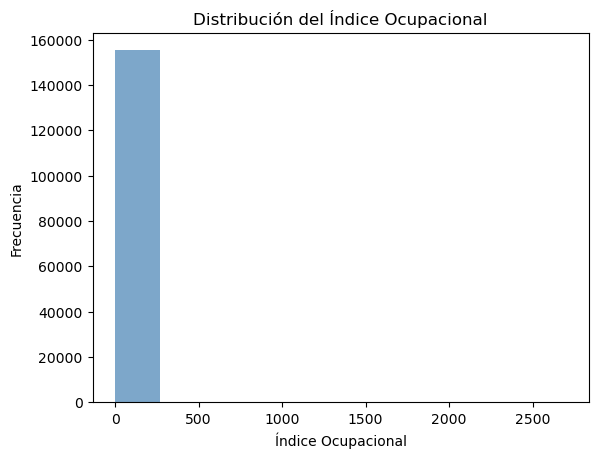

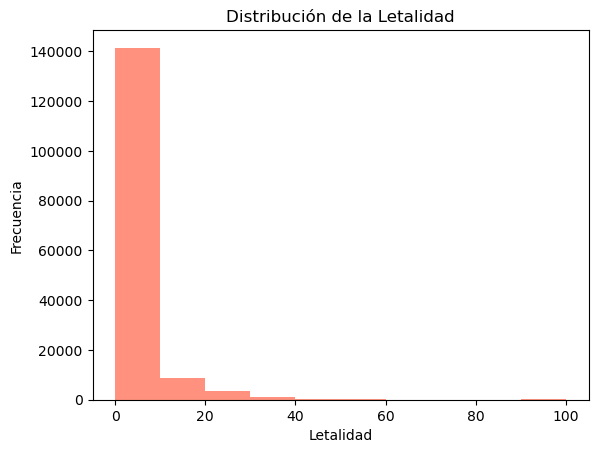

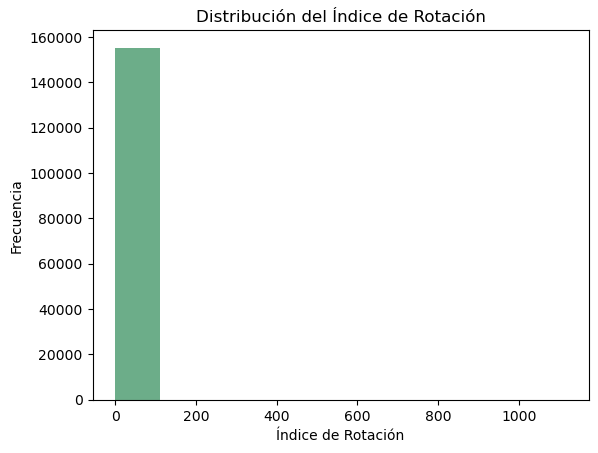

In [14]:
# Indice ocupacional
df['INDICE_OCUPACIONAL'] = pd.to_numeric(df['INDICE_OCUPACIONAL'], errors='coerce')

plt.hist(df['INDICE_OCUPACIONAL'].dropna(), bins=10, alpha=0.7, color='steelblue')
plt.xlabel('Índice Ocupacional')
plt.ylabel('Frecuencia')
plt.title('Distribución del Índice Ocupacional')
plt.show()

# Letalidad
df['LETALIDAD'] = pd.to_numeric(df['LETALIDAD'], errors='coerce')

plt.hist(df['LETALIDAD'].dropna(), bins=10, alpha=0.7, color='tomato')
plt.xlabel('Letalidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Letalidad')
plt.show()

# Indice de rotacion
df['INDICE_ROTACION'] = pd.to_numeric(df['INDICE_ROTACION'], errors='coerce')

plt.hist(df['INDICE_ROTACION'].dropna(), bins=10, alpha=0.7, color='seagreen')
plt.xlabel('Índice de Rotación')
plt.ylabel('Frecuencia')
plt.title('Distribución del Índice de Rotación')
plt.show()

C:\Users\gogyt\AppData\Local\Temp\ipykernel_3788\838213820.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


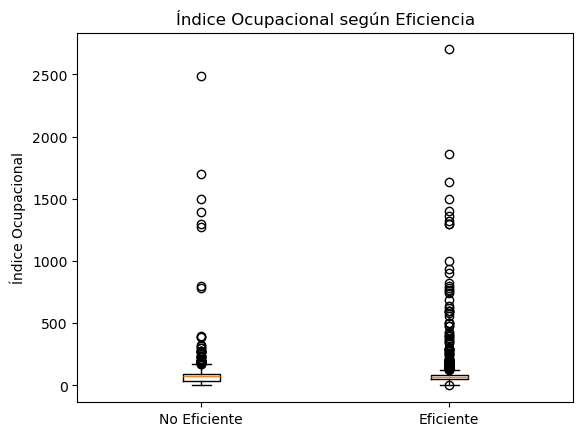

C:\Users\gogyt\AppData\Local\Temp\ipykernel_3788\838213820.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


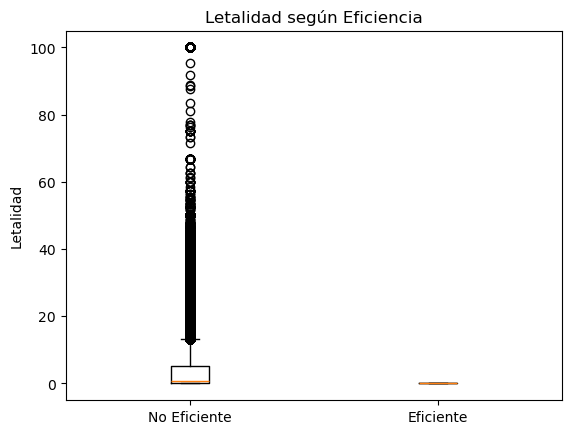

C:\Users\gogyt\AppData\Local\Temp\ipykernel_3788\838213820.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


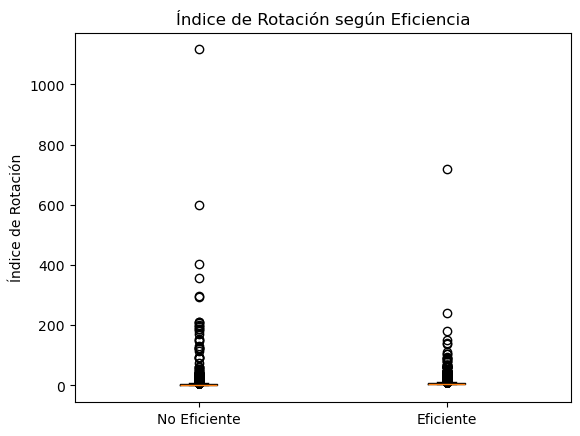

In [15]:
# Boxplot de Índice Ocupacional por eficiencia
plt.boxplot(
    [df.loc[df['EFICIENCIA'] == 0, 'INDICE_OCUPACIONAL'].dropna(),
     df.loc[df['EFICIENCIA'] == 1, 'INDICE_OCUPACIONAL'].dropna()],
    labels=['No Eficiente', 'Eficiente']
)
plt.ylabel('Índice Ocupacional')
plt.title('Índice Ocupacional según Eficiencia')
plt.show()

# Boxplot de Letalidad por eficiencia
plt.boxplot(
    [df.loc[df['EFICIENCIA'] == 0, 'LETALIDAD'].dropna(),
     df.loc[df['EFICIENCIA'] == 1, 'LETALIDAD'].dropna()],
    labels=['No Eficiente', 'Eficiente']
)
plt.ylabel('Letalidad')
plt.title('Letalidad según Eficiencia')
plt.show()

# Boxplot de Índice de Rotación por eficiencia
plt.boxplot(
    [df.loc[df['EFICIENCIA'] == 0, 'INDICE_ROTACION'].dropna(),
     df.loc[df['EFICIENCIA'] == 1, 'INDICE_ROTACION'].dropna()],
    labels=['No Eficiente', 'Eficiente']
)
plt.ylabel('Índice de Rotación')
plt.title('Índice de Rotación según Eficiencia')
plt.show()

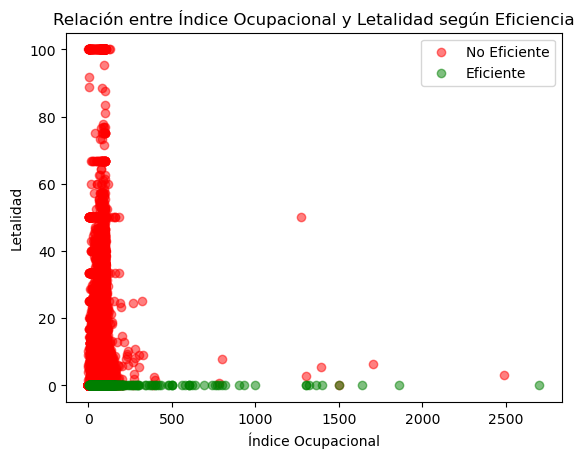

In [16]:
# Asegurar tipo numérico
df['INDICE_OCUPACIONAL'] = pd.to_numeric(df['INDICE_OCUPACIONAL'], errors='coerce')
df['LETALIDAD'] = pd.to_numeric(df['LETALIDAD'], errors='coerce')

# Separar por eficiencia
eficiente = df[df['EFICIENCIA'] == 1]
no_eficiente = df[df['EFICIENCIA'] == 0]

plt.scatter(no_eficiente['INDICE_OCUPACIONAL'], no_eficiente['LETALIDAD'], alpha=0.5, label='No Eficiente', color='red')
plt.scatter(eficiente['INDICE_OCUPACIONAL'], eficiente['LETALIDAD'], alpha=0.5, label='Eficiente', color='green')
plt.xlabel('Índice Ocupacional')
plt.ylabel('Letalidad')
plt.title('Relación entre Índice Ocupacional y Letalidad según Eficiencia')
plt.legend()
plt.show()


# **1. c. Exploración, limpieza y transformación de datos**

In [17]:
# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
display(df.head())

# Información general del dataset
print("\nInformación general del dataset:")
print(df.info())

# Descripción estadística de las variables numéricas
print("\nDescripción estadística de las variables numéricas:")
display(df.describe().T)


# Revisión de valores únicos en columnas categóricas
print("\nValores únicos en columnas categóricas:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} valores únicos")


Primeras filas del dataset:


,PERIODO,TIPO_PERTENENCIA,COD_SSS,GLOSA_SSS,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,COD_AREA_FUNCIONAL,AREA_FUNCIONAL,MES,DIAS_CAMAS_OCUPADAS,...,DIAS_ESTADA,NUMERO_EGRESOS,EGRESOS_FALLECIDOS,TRASLADOS,INDICE_OCUPACIONAL,PROMEDIO_CAMAS_DISPONIBLE,PROMEDIO_DIAS_ESTADA,LETALIDAD,INDICE_ROTACION,EFICIENCIA
0,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,1,139,...,115,9,7,12,74.73,6.0,5.48,33.33,3.50,0
1,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,2,103,...,164,7,4,21,61.31,6.0,5.86,14.29,4.67,0
2,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,3,117,...,98,15,9,12,62.90,6.0,3.63,33.33,4.50,0
3,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,4,126,...,114,7,5,17,70.00,6.0,4.75,20.83,4.00,0
4,2014,1,1,Arica,101100,Hospital Dr Juan Noé Crevanni (Arica),405,Área Cuidados Intensivos Adultos,5,141,...,165,11,7,19,75.81,6.0,5.50,23.33,5.00,0



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155339 entries, 0 to 155338
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PERIODO                    155339 non-null  int64  
 1   TIPO_PERTENENCIA           155339 non-null  int64  
 2   COD_SSS                    155339 non-null  int64  
 3   GLOSA_SSS                  155339 non-null  object 
 4   CODIGO_ESTABLECIMIENTO     155339 non-null  int64  
 5   ESTABLECIMIENTO            155339 non-null  object 
 6   COD_AREA_FUNCIONAL         155339 non-null  int64  
 7   AREA_FUNCIONAL             155339 non-null  object 
 8   MES                        155339 non-null  int64  
 9   DIAS_CAMAS_OCUPADAS        155339 non-null  int64  
 10  DIAS_CAMAS_DISPONIBLES     155339 non-null  int64  
 11  DIAS_ESTADA                155339 non-null  int64  
 12  NUMERO_EGRESOS             155339 non-null  int64  


,count,mean,std,min,25%,50%,75%,max
PERIODO,155339.0,2019.387617,3.352434,2014.0,2016.00,2019.00,2022.00,2025.0
TIPO_PERTENENCIA,155339.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
COD_SSS,155339.0,15.074708,7.850217,1.0,9.00,15.00,21.00,33.0
CODIGO_ESTABLECIMIENTO,155339.0,115453.944470,9180.123477,101100.0,109100.00,115105.00,121114.00,201319.0
COD_AREA_FUNCIONAL,155339.0,404.493585,19.421910,330.0,403.00,407.00,414.00,429.0
MES,155339.0,6.386194,3.427152,1.0,3.00,6.00,9.00,12.0
DIAS_CAMAS_OCUPADAS,155339.0,551.042462,884.114446,0.0,80.00,247.00,625.00,14677.0
DIAS_CAMAS_DISPONIBLES,155339.0,704.691726,984.305521,0.0,180.00,372.00,814.00,24800.0
DIAS_ESTADA,155339.0,544.711985,999.753619,0.0,61.00,225.00,598.00,96898.0
NUMERO_EGRESOS,155339.0,75.019763,125.672210,0.0,7.00,26.00,85.00,1700.0



Valores únicos en columnas categóricas:
GLOSA_SSS: 32 valores únicos
ESTABLECIMIENTO: 313 valores únicos
AREA_FUNCIONAL: 32 valores únicos


In [18]:
# Contar valores nulos totales
print("Valores nulos totales antes de limpiar:")
print(df.isnull().sum().sum())

# Eliminar filas con valores nulos en variables relevantes
variables_relevantes = ['INDICE_OCUPACIONAL', 'LETALIDAD', 'INDICE_ROTACION']
df_limpio = df.dropna(subset=variables_relevantes)

print(f"\nFilas originales: {len(df)}, Filas después de eliminar nulos: {len(df_limpio)}")

# Detección de valores atípicos usando el rango intercuartílico (IQR)
for col in variables_relevantes:
    Q1 = df_limpio[col].quantile(0.25)
    Q3 = df_limpio[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_limpio = df_limpio[(df_limpio[col] >= limite_inferior) & (df_limpio[col] <= limite_superior)]

print(f"Filas después de eliminar outliers: {len(df_limpio)}")

# Volver a calcular estadísticas con los datos limpios
print("\nDescripción estadística después de limpiar los datos:")
display(df_limpio.describe().T)


Valores nulos totales antes de limpiar:
0

Filas originales: 155339, Filas después de eliminar nulos: 155339
Filas después de eliminar outliers: 134623

Descripción estadística después de limpiar los datos:


,count,mean,std,min,25%,50%,75%,max
PERIODO,134623.0,2019.370932,3.356942,2014.0,2016.00,2019.00,2022.00,2025.00
TIPO_PERTENENCIA,134623.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
COD_SSS,134623.0,15.256613,7.895801,1.0,9.00,15.00,21.00,33.00
CODIGO_ESTABLECIMIENTO,134623.0,115626.908805,9172.164413,101100.0,109101.00,115109.00,121116.00,201319.00
COD_AREA_FUNCIONAL,134623.0,405.134606,19.119196,330.0,403.00,407.00,415.00,429.00
MES,134623.0,6.386672,3.434647,1.0,3.00,6.00,9.00,12.00
DIAS_CAMAS_OCUPADAS,134623.0,561.532539,918.919798,0.0,70.00,238.00,632.00,10098.00
DIAS_CAMAS_DISPONIBLES,134623.0,723.970599,1022.596060,0.0,180.00,372.00,840.00,24800.00
DIAS_ESTADA,134623.0,555.536290,1024.941964,0.0,52.00,217.00,605.00,96898.00
NUMERO_EGRESOS,134623.0,78.911679,130.832013,0.0,6.00,27.00,91.00,1700.00


In [19]:
# Copiar el dataset limpio
df_transformado = df_limpio.copy()

# Transformar variables categóricas en numéricas (Label Encoding)
columnas_categoricas = ['GLOSA_SSS', 'AREA_FUNCIONAL', 'ESTABLECIMIENTO']
le = LabelEncoder()
for col in columnas_categoricas:
    if col in df_transformado.columns:
        df_transformado[col] = le.fit_transform(df_transformado[col].astype(str))

print("\nColumnas categóricas transformadas a numéricas correctamente.")

# Estandarización de variables numéricas
columnas_numericas = ['INDICE_OCUPACIONAL', 'LETALIDAD', 'INDICE_ROTACION']
scaler = StandardScaler()
df_transformado[columnas_numericas] = scaler.fit_transform(df_transformado[columnas_numericas])

print("Variables numéricas estandarizadas correctamente.")

# Verificar el resultado final
print("\nVista general de los datos transformados:")
display(df_transformado.head())



Columnas categóricas transformadas a numéricas correctamente.
Variables numéricas estandarizadas correctamente.

Vista general de los datos transformados:


,PERIODO,TIPO_PERTENENCIA,COD_SSS,GLOSA_SSS,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,COD_AREA_FUNCIONAL,AREA_FUNCIONAL,MES,DIAS_CAMAS_OCUPADAS,...,DIAS_ESTADA,NUMERO_EGRESOS,EGRESOS_FALLECIDOS,TRASLADOS,INDICE_OCUPACIONAL,PROMEDIO_CAMAS_DISPONIBLE,PROMEDIO_DIAS_ESTADA,LETALIDAD,INDICE_ROTACION,EFICIENCIA
12,2014,1,1,6,101100,83,411,1,1,83,...,73,0,0,10,0.168594,4.03,7.30,-0.549945,-1.471082,0
13,2014,1,1,6,101100,83,411,1,2,48,...,79,1,0,10,-0.583397,4.00,7.18,-0.549945,-0.302289,0
14,2014,1,1,6,101100,83,411,1,3,29,...,34,4,0,8,-1.205370,4.00,2.83,-0.549945,-0.196035,0
15,2014,1,1,6,101100,83,411,1,4,21,...,19,5,0,5,-1.393528,4.00,1.90,-0.549945,-0.408543,0
16,2014,1,1,6,101100,83,411,1,5,60,...,37,5,0,11,-0.406740,4.00,2.31,-0.549945,0.228981,1


Distribución de clases (dataset):
EFICIENCIA
0    95880
1    38743
Name: count, dtype: int64

Proporción (%):
EFICIENCIA
0    71.221114
1    28.778886
Name: proportion, dtype: float64

Desbalance detectado (>70/30). Aplicando SMOTE sobre el conjunto de entrenamiento...
Distribución después de SMOTE:
EFICIENCIA
1    76704
0    76704
Name: count, dtype: int64

Entrenando y ajustando: KNN
Mejor params KNN: {'n_neighbors': 7}
Accuracy: 0.9972 | Precision: 0.9905 | Recall: 0.9999 | F1: 0.9952 | ROC AUC: 0.9996 if available

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19176
           1       0.99      1.00      1.00      7749

    accuracy                           1.00     26925
   macro avg       1.00      1.00      1.00     26925
weighted avg       1.00      1.00      1.00     26925

Confusion matrix:
[[19102    74]
 [    1  7748]]

Entrenando y ajustando: AdaBoost
Mejor params AdaBoost: {'n_estimators': 50

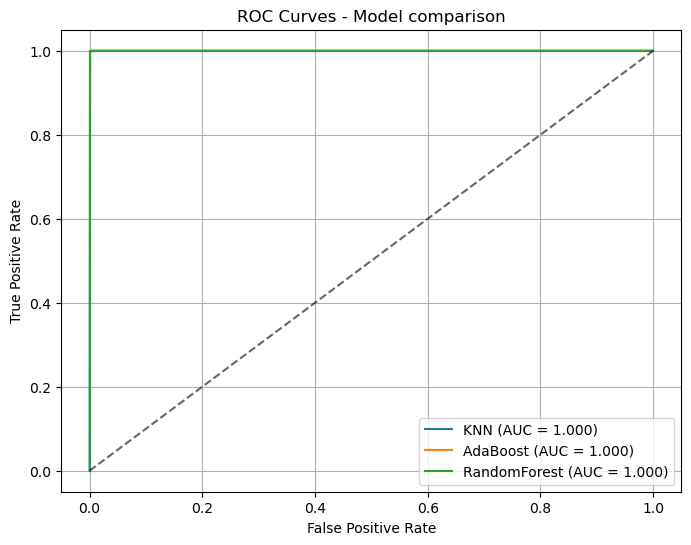


Importancia de variables (RandomForest):
INDICE_ROTACION       0.544053
LETALIDAD             0.354597
INDICE_OCUPACIONAL    0.101350
dtype: float64


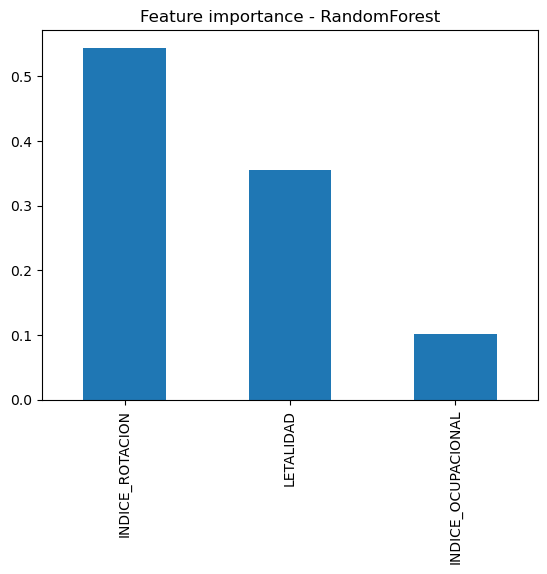


Mejor modelo por AUC: AdaBoost (AUC=1.000)

Punto 2 completado: modelos entrenados y métricas generadas.


In [20]:
# ==========================
# Punto 2 - Clasificación
# ==========================

# Preparar datos (usar df_transformado si existe)
try:
    df_used = df_transformado.copy()
except NameError:
    try:
        df_used = df_limpio.copy()
    except NameError:
        df_used = df.copy()

features = ['INDICE_OCUPACIONAL', 'LETALIDAD', 'INDICE_ROTACION']
for f in features:
    df_used[f] = pd.to_numeric(df_used[f], errors='coerce')

# Eliminar filas con NaN en features o target
df_used = df_used.dropna(subset=features + ['EFICIENCIA'])
X = df_used[features]
y = df_used['EFICIENCIA'].astype(int)

# Revisar distribución de clases
print('Distribución de clases (dataset):')
print(y.value_counts())
print('\nProporción (%):')
print(y.value_counts(normalize=True)*100)

# Dividir en train/test con estratificación
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar SMOTE si hay desbalance > 70/30
from imblearn.over_sampling import SMOTE
imbalance_ratio = y.value_counts(normalize=True).max()
apply_smote = imbalance_ratio > 0.7
if apply_smote:
    print('\nDesbalance detectado (>70/30). Aplicando SMOTE sobre el conjunto de entrenamiento...')
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print('Distribución después de SMOTE:')
    print(y_train.value_counts())
else:
    print('\nNo se aplicó SMOTE (balance aceptable).')

# Modelos a evaluar
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
models = {
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Parámetros para GridSearch (ligero)
param_grids = {
    'KNN': {'n_neighbors': [3,5,7]},
    'AdaBoost': {'n_estimators': [50,100]},
    'RandomForest': {'n_estimators': [50,100], 'max_depth': [5, None]}
}

best_estimators = {}
results = {}
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"\nEntrenando y ajustando: {name}")
    grid = GridSearchCV(model, param_grids[name], scoring='roc_auc', cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    best_estimators[name] = best
    print(f"Mejor params {name}: {grid.best_params_}")
    # Predicciones y métricas
    y_pred = best.predict(X_test)
    if hasattr(best, 'predict_proba'):
        y_proba = best.predict_proba(X_test)[:,1]
    else:
        # algunos clasificadores usan decision_function
        try:
            y_proba = best.decision_function(X_test)
        except Exception:
            y_proba = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC AUC: {auc:.4f} if available")
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    results[name] = {'model': best, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

# Curvas ROC comparadas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc as calc_auc
plt.figure(figsize=(8,6))
for name, info in results.items():
    model = info['model']
    if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):
        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(X_test)[:,1]
        else:
            prob = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, prob)
        roc_auc = calc_auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Importancia de variables (si RandomForest)
if 'RandomForest' in best_estimators:
    rf = best_estimators['RandomForest']
    try:
        importances = rf.feature_importances_
        fi = pd.Series(importances, index=features).sort_values(ascending=False)
        print('\nImportancia de variables (RandomForest):')
        print(fi)
        fi.plot(kind='bar', title='Feature importance - RandomForest')
        plt.show()
    except Exception as e:
        print('No se pudo obtener importancia de características:', e)

# Guardar el mejor modelo por AUC
best_by_auc = sorted([(k,v['auc']) for k,v in results.items() if v['auc'] is not None], key=lambda x: x[1] if x[1] is not None else -1, reverse=True)
if best_by_auc:
    best_name = best_by_auc[0][0]
    print(f"\nMejor modelo por AUC: {best_name} (AUC={best_by_auc[0][1]:.3f})")
    best_model = results[best_name]['model']
else:
    # fallback por F1
    best_name = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)[0][0]
    best_model = results[best_name]['model']
    print(f"\nMejor modelo por F1: {best_name}")

print('\nPunto 2 completado: modelos entrenados y métricas generadas.')